In [1]:
## Relevant modules and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from datetime import datetime as dt
pd.set_option('display.max_rows', 500)

# Obtaining MTA Turnstile Data

In [2]:
# From MTA Challenge Solutions, Function for obtaining MTA data from MTA website
# Timeframe was January 2019 to August 2019, full data weeklist in week_nums
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190105, 190112, 190119, 190126, 190202, 190209, 190216, 190223, 190302, 190309, 190316, 190323, 190330, 190406, 190413, 190420, 190427, 190504, 190511, 190518, 190525, 190601, 190608, 190615, 190622, 190629, 190706, 190713, 190720, 190727, 190803, 190810, 190817, 190824, 190831]
turnstiles_df = get_data(week_nums)

# Formatting and Cleaning Data

In [3]:
#This cell adds turnstile and date time fields for easier identification
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, format="%m/%d/%Y %H:%M:%S")
turnstiles_df["TURNSTILE"] = turnstiles_df["C/A"]+turnstiles_df["UNIT"]+turnstiles_df["SCP"]+turnstiles_df["STATION"]
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df = turnstiles_df.reset_index(drop=True)

In [4]:
#This cell removes rows from the dataframe that do not end exactly on the hour because the cumulative nature of the 
# entries and exits data makes them redundant, also adds further date time fields
index_names = turnstiles_df[ (turnstiles_df['DATE_TIME'].dt.minute != 0) | (turnstiles_df['DATE_TIME'].dt.second != 0)].index
turnstiles_df['DAY'] = turnstiles_df['DATE_TIME'].dt.dayofweek
turnstiles_df['TIME'] = turnstiles_df['DATE_TIME'].dt.time
turnstiles_df['MONTH'] = turnstiles_df['DATE_TIME'].dt.month
turnstiles_df.drop(index_names, inplace = True)

In [5]:
#This cell groups the data by turnstile and sorts them by time in order to use the diff function to obtain
# the exact entries and exits between time periods
turnstiles_df_sorted = turnstiles_df.sort_values(['TURNSTILE', 'DATE_TIME'])
turnstiles_df_sorted = turnstiles_df_sorted.reset_index(drop = True)
turnstiles_grouped = turnstiles_df_sorted.groupby(['TURNSTILE'])
turnstiles_df_sorted['DAILY_ENTRIES'] = turnstiles_grouped['ENTRIES'].transform(pd.Series.diff)
turnstiles_df_sorted['DAILY_EXITS'] = turnstiles_grouped['EXITS'].transform(pd.Series.diff)

In [6]:
#This cell cleans up data from the turnstiles that either count backwards or resets resulting in large incorrect values
turnstiles_df_sorted['DAILY_ENTRIES'] = abs(turnstiles_df_sorted['DAILY_ENTRIES'])
turnstiles_df_sorted['DAILY_EXITS'] = abs(turnstiles_df_sorted['DAILY_EXITS'])
turnstiles_df_sorted['DAILY_ENTRIES'][turnstiles_df_sorted['DAILY_ENTRIES'] >= turnstiles_df_sorted['DAILY_ENTRIES'].quantile(.999)] = turnstiles_df_sorted['DAILY_ENTRIES'].quantile(.999)
turnstiles_df_sorted['DAILY_EXITS'][turnstiles_df_sorted['DAILY_EXITS'] >= turnstiles_df_sorted['DAILY_EXITS'].quantile(.999)] = turnstiles_df_sorted['DAILY_EXITS'].quantile(.999)
turnstiles_df_sorted['DAILY_ENTRIES'] = turnstiles_df_sorted['DAILY_ENTRIES'].fillna(0)
turnstiles_df_sorted['DAILY_EXITS'] = turnstiles_df_sorted['DAILY_EXITS'].fillna(0)
turnstiles_df_sorted['TRAFFIC'] = turnstiles_df_sorted['DAILY_ENTRIES'] + turnstiles_df_sorted['DAILY_EXITS']

<ipython-input-6-f5495ef240ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df_sorted['DAILY_ENTRIES'][turnstiles_df_sorted['DAILY_ENTRIES'] >= turnstiles_df_sorted['DAILY_ENTRIES'].quantile(.999)] = turnstiles_df_sorted['DAILY_ENTRIES'].quantile(.999)
<ipython-input-6-f5495ef240ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df_sorted['DAILY_EXITS'][turnstiles_df_sorted['DAILY_EXITS'] >= turnstiles_df_sorted['DAILY_EXITS'].quantile(.999)] = turnstiles_df_sorted['DAILY_EXITS'].quantile(.999)


# Visualizations

In [7]:
#This cell is used to determine the top stations by volume
top_stations = turnstiles_df_sorted.groupby('STATION')['DAILY_ENTRIES'].sum().reset_index()
top_stations = top_stations.sort_values('DAILY_ENTRIES',ascending=False).head(10).set_index('STATION')

## Top Stations Bar Chart

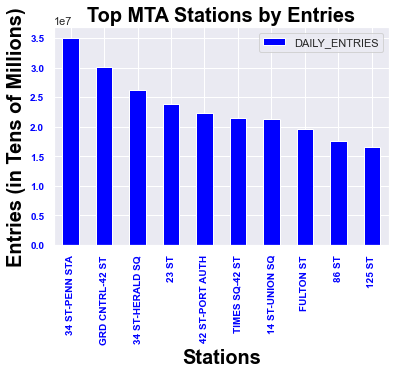

In [8]:
top_stations.plot( kind="bar", color='blue')
plt.title('Top MTA Stations by Entries',fontsize = 20, weight = 'bold',color='black')
plt.ylabel('Entries (in Tens of Millions)',fontsize = 20, weight = 'bold',color='black');
plt.xlabel('Stations',fontsize = 20, weight = 'bold',color='black');
plt.xticks(fontsize = 10, weight = 'bold',color='blue')
plt.yticks(fontsize = 10, weight = 'bold',color='blue')
plt.savefig("top_station_entries.png",dpi=300, bbox_inches='tight')

In [9]:
#From Kaggle MTA Analysis, Heatmap using seaborn visualizations, this cell focuses on 1 station at a time
# Station of interest is changed manually, and rerun for top 10 stations
station_of_interest = '34 ST-PENN STA'
tds_station = turnstiles_df_sorted[turnstiles_df_sorted['STATION'] == station_of_interest]

In [10]:
#Grouping by Station and Time and obtaining overall daily traffic
tds_station_grouped = tds_station.groupby(['STATION','DATE_TIME'], as_index=False)
stations_day_time = tds_station_grouped[['DAILY_ENTRIES', 'DAILY_EXITS','TRAFFIC']].sum()
rounded_day_time = stations_day_time.set_index('DATE_TIME').groupby(['STATION'])
rounded_day_time = rounded_day_time.resample('4H', convention='end').sum()
rounded_day_time = rounded_day_time.reset_index()

In [11]:
#Obtaining new fields for time
stations_day_time['DAY'] = stations_day_time['DATE_TIME'].dt.dayofweek
stations_day_time['TIME'] = stations_day_time['DATE_TIME'].dt.time

In [12]:
#Creating final data subsets for plotting
stations_day_time_group = stations_day_time.groupby(['STATION','DAY','TIME'])
stations_day_time_group_ent = stations_day_time_group['DAILY_ENTRIES'].mean().reset_index()
stations_day_time_group_ext = stations_day_time_group['DAILY_EXITS'].mean().reset_index()

## Exits Hourly Heatmap

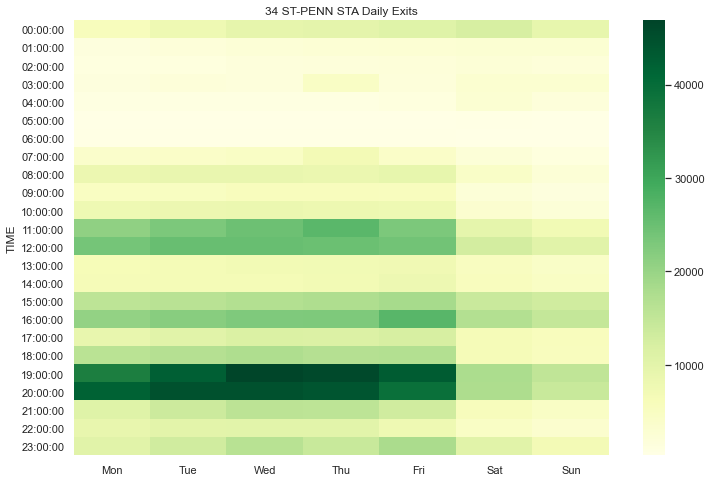

In [13]:
#Plots for Exits heatmaps
draw_station_ent = stations_day_time_group_ent
draw_station_ext = stations_day_time_group_ext

weekdays = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
station_heatmap_ent = draw_station_ent.set_index(['DAY', 'TIME'])['DAILY_ENTRIES'].unstack(0)
station_heatmap_ent.columns = [weekdays[c] for c in station_heatmap_ent.columns]
station_heatmap_ext = draw_station_ext.set_index(['DAY', 'TIME'])['DAILY_EXITS'].unstack(0)
station_heatmap_ext.columns = [weekdays[c] for c in station_heatmap_ext.columns]

fig, ax = plt.subplots(figsize=(12, 8))
ax.set(title=station_of_interest + ' Daily Exits', xlabel='Weekday', ylabel='Time')
sns.heatmap(station_heatmap_ext,ax=ax, cmap='YlGn')
plt.savefig("station_heatmap_ext0.png",dpi=300, bbox_inches='tight')

## Entries Hourly Heatmap

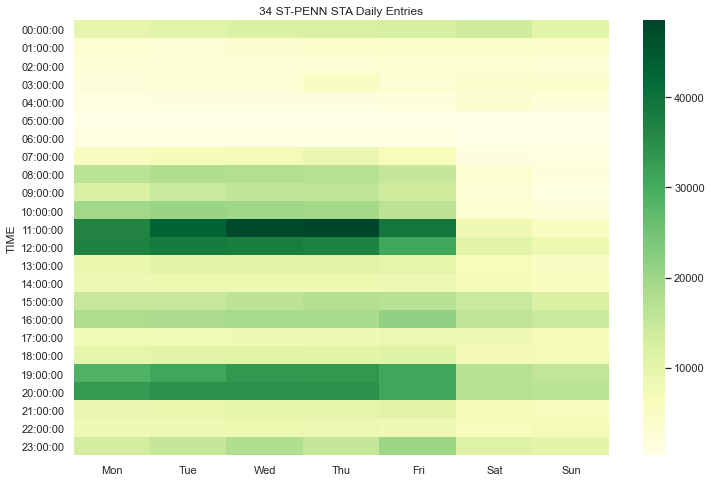

In [14]:
# Same as previous, but for Entries
fig, ax = plt.subplots(figsize=(12, 8))
ax.set(title=station_of_interest + ' Daily Entries', xlabel='Weekday', ylabel='Time')
sns.heatmap(station_heatmap_ent,ax=ax, cmap='YlGn')
plt.savefig("station_heatmap_ent0.png",dpi=300, bbox_inches='tight')

## Weekly Station Traffic Comparisons

In [34]:
#Filtering to daily
daily_traffic_series = turnstiles_df_sorted.groupby(['DAY','STATION']).sum().reset_index()
daily_traffic_series.index = daily_traffic_series['DAY']

,DAY,STATION,ENTRIES,EXITS,MONTH,DAILY_ENTRIES,DAILY_EXITS,TRAFFIC
DAY,,,,,,,,
0,0,1 AV,364707599498,313888216886,9985,550263.0,623583.0,1173846.0
0,0,103 ST,83879428561,144453825922,14970,946540.0,668134.0,1614674.0
0,0,103 ST-CORONA,14909983747,15011582990,9018,651042.0,459091.0,1110133.0
0,0,104 ST,1018202000618,741028335703,9018,147923.0,66375.0,214298.0
0,0,110 ST,7889002090,7556978647,6009,332666.0,296912.0,629578.0
...,...,...,...,...,...,...,...,...
6,6,WOODLAWN,6340900339,2479594842,4935,114291.0,34605.0,148896.0
6,6,WORLD TRADE CTR,333815358939,384708305878,17392,183601.0,147977.0,331578.0
6,6,WTC-CORTLANDT,153353208992,424575315,34579,194117.0,142449.0,336566.0


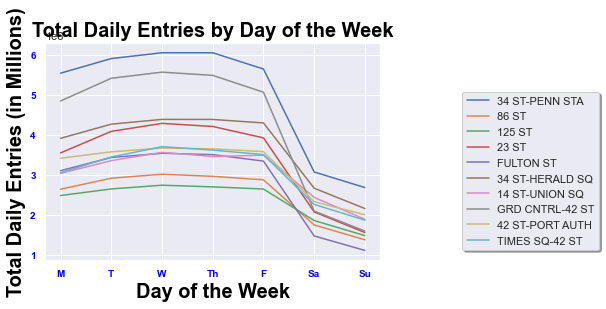

In [35]:
# Individual series graphs plotted simultaneously
series  = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION']  == '34 ST-PENN STA']
series1 = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION'] == '86 ST']
series2 = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION'] == '125 ST']
series3 = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION'] == '23 ST']
series4 = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION'] == 'FULTON ST']
series5 = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION'] == '34 ST-HERALD SQ']
series6 = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION'] == '14 ST-UNION SQ']
series7 = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION'] == 'GRD CNTRL-42 ST']
series8 = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION'] == '42 ST-PORT AUTH']
series9 = daily_traffic_series['DAILY_ENTRIES'][daily_traffic_series['STATION'] == 'TIMES SQ-42 ST']
series.plot()
series1.plot()
series2.plot()
series3.plot()
series4.plot()
series5.plot()
series6.plot()
series7.plot()
series8.plot()
series9.plot()
ticks_x = np.linspace(0, 6, 7)
days = ['M','T','W','Th','F','Sa','Su']
plt.title('Total Daily Entries by Day of the Week',fontsize = 20, weight = 'bold',color='black')
plt.ylabel('Total Daily Entries (in Millions)',fontsize = 20, weight = 'bold',color='black');
plt.xlabel('Day of the Week',fontsize = 20, weight = 'bold',color='black');
plt.xticks(ticks_x,days,fontsize = 10, weight = 'bold',color='blue')
plt.yticks(fontsize = 10, weight = 'bold',color='blue')
plt.legend(['34 ST-PENN STA','86 ST','125 ST','23 ST','FULTON ST','34 ST-HERALD SQ','14 ST-UNION SQ','GRD CNTRL-42 ST','42 ST-PORT AUTH','TIMES SQ-42 ST'],loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.savefig("weekly_chart.png",dpi=300, bbox_inches='tight')

# Obtaining Secondary Data on Income

In [16]:
df=pd.read_csv("nyc-rolling-sales.csv")

# Focusing on Neighborhoods Surrounding Top Stations

In [17]:
#Storing individual neighborhood median sales prices
df_murr_hill =  df["SALE PRICE"][(df["NEIGHBORHOOD"] == "MURRAY HILL") & (df['SALE PRICE'] != ' -  ')]
a = df_murr_hill.astype(dtype=int).quantile(q=.5)
df_mid_west =  df["SALE PRICE"][(df["NEIGHBORHOOD"] == "MIDTOWN WEST") & (df['SALE PRICE'] != ' -  ')]
b = df_mid_west.astype(dtype=int).quantile(q=.5)
df_mid_east =  df["SALE PRICE"][(df["NEIGHBORHOOD"] == "MIDTOWN EAST") & (df['SALE PRICE'] != ' -  ')]
c = df_mid_east.astype(dtype=int).quantile(q=.5)
df_fin_dist =  df["SALE PRICE"][(df["NEIGHBORHOOD"] == "FINANCIAL") & (df['SALE PRICE'] != ' -  ')]
d = df_fin_dist.astype(dtype=int).quantile(q=.5)
df_flat_iron =  df["SALE PRICE"][(df["NEIGHBORHOOD"] == "FLATIRON") & (df['SALE PRICE'] != ' -  ')]
e = df_flat_iron.astype(dtype=int).quantile(q=.5)
df_upp_est =  df["SALE PRICE"][(df["NEIGHBORHOOD"] == "UPPER EAST SIDE (79-96)") & (df['SALE PRICE'] != ' -  ')]
f = df_upp_est.astype(dtype=int).quantile(q=.5)

# Plotting Sales Data

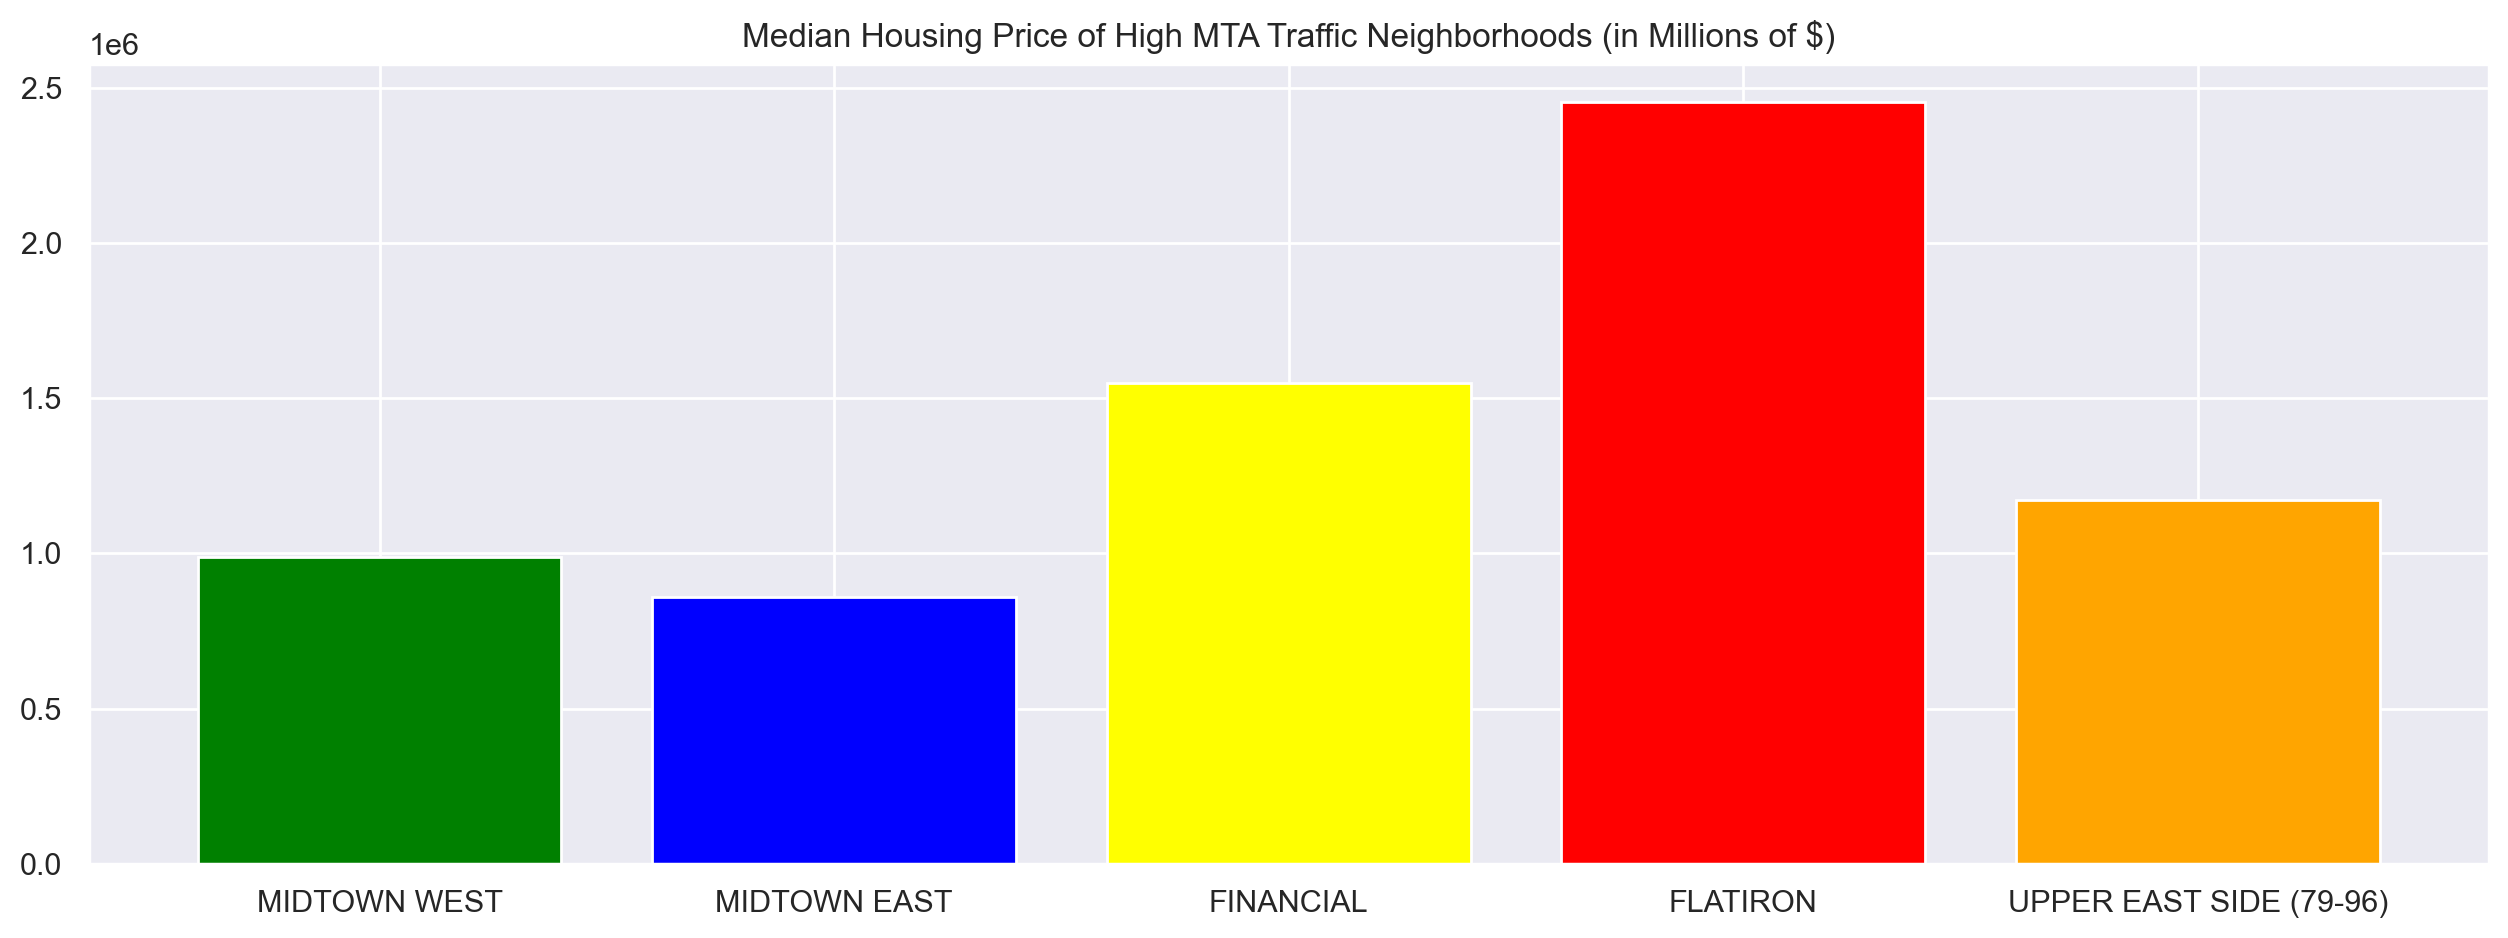

<Figure size 432x288 with 0 Axes>

In [18]:
# Bar Chart for Sales data
listo1 = [b, c, d, e, f]
listo2 = ["MIDTOWN WEST", "MIDTOWN EAST", "FINANCIAL", "FLATIRON", "UPPER EAST SIDE (79-96)"]
fig = plt.figure(dpi=200)
ax = fig.add_axes([0,0,2,1])
ax.bar(listo2,listo1,color = ['green','blue','yellow','red','orange'])
plt.title('Median Housing Price of High MTA Traffic Neighborhoods (in Millions of $)')
plt.show()
plt.savefig("Neighborhood_House_Price.png")